# BICS_ABM
Ethan Roubenoff

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from BICS_ABM import BICS_ABM, VaccineRule
import time
from joblib import Parallel, delayed
from scipy.stats.qmc import LatinHypercube
from scipy.stats import norm, uniform, randint
from scipy.signal import find_peaks
import datetime

import collections
import re
from copy import deepcopy

import pickle

/Users/eroubenoff/BICS_ABM/BICS_ABM.py:159: DtypeWarning: Columns (26,63,64,65,66,68,69,70,71,72,73,76,86,139,140,149,175,176,177,191,195,205,213,214,215,216,217,218,219,220,221,222,223,224,225,227,228,229) have mixed types. Specify dtype option on import or set low_memory=False.
  BICS = pd.read_csv("data/df_all_waves.csv", dtype_backend="numpy_nullable")


## Quick, demonstrative example:

In [2]:
t0 = time.time()
result = BICS_ABM( 
        N_HH = 100,
        SEED = 4949, 
        RHO = 0.5,
        ALPHA = 0.25,
        BETA0 =0.05,
        BETA1 = 1,
        T0 = 60,
        ISOLATION_MULTIPLIER = 1, #0.5, 
        N_VAX_DAILY = 150,
        T_REINFECTION = 24*180,
        IMPORT_CASES_VEC = [1 if i%7 == 0 else 0 for i in range(365)],
        vax_rules = [VaccineRule(general=True, hesitancy=.5)],
        VEBoost = .75,
    
#         vax_rules = [
#             VaccineRule("age > 80"),
#             VaccineRule("age > 70"),
#             VaccineRule("age > 60"),
#             VaccineRule("age > 50", hesitancy = 0.5),
#             VaccineRule("age > 40", hesitancy = 0.5),
#             VaccineRule("age > 30", hesitancy = 0.5),
#             VaccineRule(general = True, hesitancy = 0.5),
#         ],
        silent = False,
        BOOSTER_DAY = 244,
        MAX_DAYS = 10*365)

print(time.time() - t0)
result.plot_trajectory()

ValueError: Invalid parameter N_HH passed to BICS_ABM

2668
84035
3502


321912

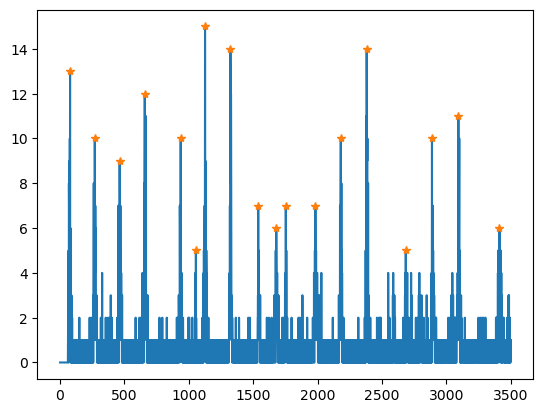

In [24]:
Cc = result.Cc
Csc = result.Csc
print(sum(Cc))
print(len(Cc))
Cc = np.add.reduceat(Cc, np.arange(0, len(Cc), 24)).tolist()
print(len(Cc))
Csc = np.add.reduceat(Csc, np.arange(0, len(Csc), 24)).tolist()
plt.plot(Cc,'-')
#plt.plot(Csc,'-')
peaks = find_peaks(Cc, height = 5, distance = 30)
plt.plot(peaks[0], peaks[1]['peak_heights'], "*")
sum(result.Ic)

In [25]:
stdate = datetime.date(2021, 1, 1)
outbreak_peaks = [stdate + datetime.timedelta(days = int(x)) for x in peaks[0]]

In [26]:
outbreak_interval = [outbreak_peaks[x+1] - outbreak_peaks[x] for x in range(len(outbreak_peaks)-2)]

In [27]:
np.mean(outbreak_interval)

datetime.timedelta(days=188, seconds=37800)

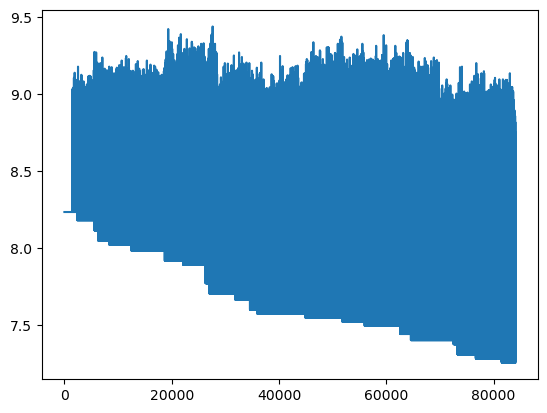

In [28]:
# Try plotting the contact rate over time

plt.plot([x/result.S[0]* 0.05 *((72+168)/2) * (.75 + .25*.25) for x in result.cr])

In [29]:
def process_sim(sim):
    # Parse beta0 and beta1 from file name
    
    ret =  {}
    N = sim.S[0] + sim.E[0]
    threshold = N * 0.01
    threshold= 2
    x = np.add.reduceat(sim.Cc, np.arange(0, len(sim.Cc), 24))
    peaks, properties = find_peaks(x, height=threshold, distance=30, width=1, rel_height=1)
    
    count = []
    for i in range(len(properties["left_ips"])):
        left_bound = round(properties["left_ips"][i])
        right_bound = round(properties["right_ips"][i])
        count.append(sum(x[left_bound:right_bound]))
            
    print(np.mean(sim._params.BETA_VEC))
    print(np.mean([sim._params.SIGMA_MIN, sim._params.SIGMA_MAX]))
    print(np.mean([x/N for x in sim.cr]))
    print(sim._params.RHO + (1-sim._params.RHO)*sim._params.ALPHA)
    ret["N"] = N
    ret["n_Cc"] = sum(sim.Cc)
    ret["n_Csc"] = sum(sim.Csc)
    ret["n_D"] = sim.D[len(sim.D)-1]
    ret["R0"] = np.mean(sim._params.BETA_VEC) * \
        np.mean([sim._params.SIGMA_MIN, sim._params.SIGMA_MAX]) * \
        np.mean([x/N for x in sim.cr]) * \
        (sim._params.RHO + (1-sim._params.RHO)*sim._params.ALPHA)
    ret["peaks"] = peaks
    ret["properties"]  = properties
    ret["num_outbreaks"] = len(peaks)
    ret["mean_time_bw_outbreaks"] = np.mean(np.diff(peaks))
    ret["avg_outbreak_size"] = np.mean(count)
    
    return ret
    

In [30]:
process_sim(result)

0.05
120.0
1.6719779242561417
0.625


{'N': 370,
 'n_Cc': 2668,
 'n_Csc': 2187,
 'n_D': 25,
 'R0': 6.269917309389578,
 'peaks': array([  78,  150,  230,  270,  327,  394,  463,  587,  617,  658,  772,
         829,  907,  937, 1003, 1055, 1126, 1323, 1390, 1475, 1539, 1606,
        1643, 1679, 1753, 1798, 1852, 1882, 1919, 1983, 2029, 2118, 2180,
        2316, 2381, 2490, 2548, 2587, 2684, 2726, 2790, 2847, 2888, 2920,
        3015, 3046, 3093, 3143, 3264, 3303, 3412, 3444, 3483]),
 'properties': {'peak_heights': array([13.,  2.,  2., 10.,  4.,  3.,  9.,  2.,  2., 12.,  2.,  2.,  2.,
         10.,  2.,  5., 15., 14.,  2.,  2.,  7.,  2.,  2.,  6.,  7.,  2.,
          2.,  3.,  2.,  7.,  4.,  2., 10.,  2., 14.,  2.,  4.,  4.,  5.,
          4.,  4.,  3., 10.,  2.,  2.,  4., 11.,  2.,  2.,  2.,  6.,  2.,
          3.]),
  'prominences': array([13.,  2.,  2., 10.,  4.,  3.,  9.,  2.,  2., 12.,  2.,  2.,  2.,
         10.,  2.,  5., 15., 14.,  2.,  2.,  7.,  2.,  2.,  6.,  7.,  2.,
          2.,  3.,  2.,  7.,  4.,  2., 10.,  2

In [55]:
sim = result
N = sim.S[0] + sim.E[0]
.10 * \
        np.mean([sim._params.SIGMA_MIN, sim._params.SIGMA_MAX]) * \
        np.mean([x/N for x in sim.cr]) * \
        (sim._params.RHO + (1-sim._params.RHO)*sim._params.ALPHA)

12.539834431921062

# Main Analysis

In [31]:
baseline_params = {
        'N_HH' : 1000,
        # SEED : 4949, 
        'RHO': 0.20,
        'ALPHA': 0.32,
        'BETA0':0.05,
        'BETA1': 0,
        'T0': 0,
        'ISOLATION_MULTIPLIER': .1, 
        'N_VAX_DAILY': 150,
        'T_REINFECTION': 365*180,
        'IMPORT_CASES_VEC': [1 if i%7== 0 else 0 for i in range(365)],
        'vax_rules': [VaccineRule(general=True, hesitancy=.25)],
        'VEBoost': .75,
        'SCHOOL_CONTACTS': True,

        'silent': True,
        'BOOSTER_DAY': -1,
        'MAX_DAYS': 10*365
   
}

## Varying B0
Varying from 0-.1


In [32]:
b0_range = np.arange(0.005, .10, .005).repeat(10)
b0_range = np.array([0.005, ])
b0_range

b0_params = deepcopy(baseline_params)
del b0_params["BETA0"]

def sim_fn(b0):
    return BICS_ABM(BETA0 = b0, **b0_params)

b0_raw = Parallel(n_jobs=8, verbose = 10)(delayed(sim_fn)(v) for v in b0_range)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  3.9min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  7.9min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  8.1min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 16.1min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 20.3min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed: 24.8min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 29.3min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed: 38.1min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed: 47.6min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed: 56.3min


[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088 

 2431 3360 1093 3223 5378 1831][4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 

 2431 3360 1093 3223 5378 1831][4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 

 2431 3360 1093 3223 5378 1831][4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 

  551 1405 4530 2039 3898 3746 4224 3199 1349 3633 1605 3339   49 5255
 4512 4730 2058 3246 5019 4511 4471 4111 2980 2053 3111 2065 1546 4521
 5150 4823 2657 3240 2715 1494 4779 2632 5150 1748 2148 4110 1329 2272
 1912 2418 5272 1463 2442   49  613  223 1291 3943 2043 3679  959  443
 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924

 2431 3360 1093 3223 5378 1831][4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 

 2431 3360 1093 3223 5378 1831][4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 

 2431 3360 1093 3223 5378 1831][4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 

 5394 3752 3487 3565 4102 3399 1312 2769 1016 2746 1873  363 1467 1508
 4069 4680 3009 2637 3670  560 2751  190 2042 1954 2724   61 1759  329
 5399 3079 2227 4983  592 1577 1618  526 2057 4715  597 5198 4764 3920
 4840 4669 3427 1967 5022 1349 2541 2489  537  402 3993 3007 1304 1715
 3982 2844 1837 4014 1944 1292 1676 4201 1795 1079 1450 4904 4476 2061
  264 4228 3063 1591 4105  692 1817  252 1445 5191  632 3875 5342 1504
 3414 2941  449 3743 1866 1309 4950 1722 3395 3959 2155 1781 1553 2368
  806 1370 5292 2460 2392  296 3998 1483 2598 4531 5333  935 4704 2904
 4418 4159 3980 4164 3481 3662 1106 3649 1931 3652 1495 5104 4652 4488
 4147  136 5171 4589 1875 2296 3073 2615 1838 1063 2270 3133 3294 2979
 4671  546 2708 2827 4404 1379 3680 1913 3569 2128  586 1374 3673  221
 3109 1414  164 3057  644 1152 4279 2164 4887 1380 5088 2820 3242 3697
 4224 2985  185 2577 1852 1685 2776 1748 3741 4549  992 5264  305 2767
 2649  957 3961 2057 3647 1296 1093 1698 4617   80 3641 4550  858 3427
 2234 

[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed: 61.5min
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed: 73.9min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 82.8min
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed: 92.0min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 102.5min



[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088

 4512 4730 2058 3246 5019 4511 4471 4111 2980 2053 3111 2065 1546 4521
 5150 4823 2657 3240 2715 1494 4779 2632 5150 1748 2148 4110 1329 2272
 1912 2418 5272 1463 2442   49  613  223 1291 3943 2043 3679  959  443
 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440

  852 2464 1377  624  825  467 2805  590  857  952 5184 1249 1404 3290
  551 1405 4530 2039 3898 3746 4224 3199 1349 3633 1605 3339   49 5255
 4512 4730 2058 3246 5019 4511 4471 4111 2980 2053 3111 2065 1546 4521
 5150 4823 2657 3240 2715 1494 4779 2632 5150 1748 2148 4110 1329 2272
 1912 2418 5272 1463 2442   49  613  223 1291 3943 2043 3679  959  443
 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905

  676  983  929 4372 4899 1703 1550  314 5164 5098 1703 2214 5028 2913
 2145 4670 2011 4826  192  844 1878   17 2675 3372 4732 4378 1870   81
 1612 3228 2131 2723 1653 3618 3065 3442 1446   71 2979 4825  309 2903
 4879 3781 3882 4418 3912 4785  467 1254  852 2999  406 1424  313 4228
 3829  280 3015 2220  495 3931 4894 3311  479 1525  432 1521 1862 4079
 4507  516  472  914  893 4780 1851 2525 1015 4541 2828 2192 2273 1093
 2304 3754 1305 4471 1170 5314 1307 2721 1569 4508  835 4584  546 3914
 3210 4265 4634 3123 3028 2423 1810  241 5003 2089 4829 4304 4398  272
 3428 2247 1332 1308 4279 1772 1145 3430   32 3200 1795 4650 1792 1806
 2021 1483 4463 3510 1289  739 2749 3873  264  395  469 5191 4007 5005
 3458 4214 5337  705 3085 5348 5406 3121  713 2575 1385 2086 1467 4742
 4048  976  556 3685 3136 5417 1024  345 3962 1078   64 4998 4902  870
 3410 2319  546 1074 5028  897 1061 4751 2541 3745 3499 2464 4432 1472
 1986 2930 1088 1990 4704 5277  146 2569 5028 4489 4441  296 4654 2779
 2726 

 4418 4159 3980 4164 3481 3662 1106 3649 1931 3652 1495 5104 4652 4488
 4147  136 5171 4589 1875 2296 3073 2615 1838 1063 2270 3133 3294 2979
 4671  546 2708 2827 4404 1379 3680 1913 3569 2128  586 1374 3673  221
 3109 1414  164 3057  644 1152 4279 2164 4887 1380 5088 2820 3242 3697
 4224 2985  185 2577 1852 1685 2776 1748 3741 4549  992 5264  305 2767
 2649  957 3961 2057 3647 1296 1093 1698 4617   80 3641 4550  858 3427
 2234 3324 1619 4085 5118  733 3911 5043   15 2994  956 1464 1386 4237
 4257 2410  670 2064 1132 2057 4109 1175 4213 4535 3809 5148 3294 3060
 4017 1234 2230  893 3535 2669 5402 1006 2909 2091  895 4250 5216 4835
  136 4820  246 4439  996 1991  322 2469  917 1729 3896 2771 1834 3404
 4051 2525 2779 3246 2123 5291 2974  404  500 3753 2454 3961 4681  893
 4578 4209 5041 4366 2067 3681 1485 1483  882 4983 1881  895 2222  705
 1990 4743 1842 4718 4131 3172 3100 1066 5337 1157 5224 1719  516 1637
 5334 3215 3716 5149 3392 1304 4839 1393  821 2941 2266 1482 5389  855
 4969 

 3414 2941  449 3743 1866 1309 4950 1722 3395 3959 2155 1781 1553 2368
  806 1370 5292 2460 2392  296 3998 1483 2598 4531 5333  935 4704 2904
 4418 4159 3980 4164 3481 3662 1106 3649 1931 3652 1495 5104 4652 4488
 4147  136 5171 4589 1875 2296 3073 2615 1838 1063 2270 3133 3294 2979
 4671  546 2708 2827 4404 1379 3680 1913 3569 2128  586 1374 3673  221
 3109 1414  164 3057  644 1152 4279 2164 4887 1380 5088 2820 3242 3697
 4224 2985  185 2577 1852 1685 2776 1748 3741 4549  992 5264  305 2767
 2649  957 3961 2057 3647 1296 1093 1698 4617   80 3641 4550  858 3427
 2234 3324 1619 4085 5118  733 3911 5043   15 2994  956 1464 1386 4237
 4257 2410  670 2064 1132 2057 4109 1175 4213 4535 3809 5148 3294 3060
 4017 1234 2230  893 3535 2669 5402 1006 2909 2091  895 4250 5216 4835
  136 4820  246 4439  996 1991  322 2469  917 1729 3896 2771 1834 3404
 4051 2525 2779 3246 2123 5291 2974  404  500 3753 2454 3961 4681  893
 4578 4209 5041 4366 2067 3681 1485 1483  882 4983 1881  895 2222  705
 1990 

 4051 2525 2779 3246 2123 5291 2974  404  500 3753 2454 3961 4681  893
 4578 4209 5041 4366 2067 3681 1485 1483  882 4983 1881  895 2222  705
 1990 4743 1842 4718 4131 3172 3100 1066 5337 1157 5224 1719  516 1637
 5334 3215 3716 5149 3392 1304 4839 1393  821 2941 2266 1482 5389  855
 4969 1307  254 2802 4713 3993  946 2057 1683  569 1313 2721 2680 4830
 1093 3022 2120  828 5084 3851 4463 1565  469 2989  312 1372 1678  296
 2367  505 1341 3286 2122 1638 3280 4274 2967 1296 4426 1483 1073 1011
  676  983  929 4372 4899 1703 1550  314 5164 5098 1703 2214 5028 2913
 2145 4670 2011 4826  192  844 1878   17 2675 3372 4732 4378 1870   81
 1612 3228 2131 2723 1653 3618 3065 3442 1446   71 2979 4825  309 2903
 4879 3781 3882 4418 3912 4785  467 1254  852 2999  406 1424  313 4228
 3829  280 3015 2220  495 3931 4894 3311  479 1525  432 1521 1862 4079
 4507  516  472  914  893 4780 1851 2525 1015 4541 2828 2192 2273 1093
 2304 3754 1305 4471 1170 5314 1307 2721 1569 4508  835 4584  546 3914
 3210 

 5150 4823 2657 3240 2715 1494 4779 2632 5150 1748 2148 4110 1329 2272
 1912 2418 5272 1463 2442   49  613  223 1291 3943 2043 3679  959  443
 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297

 4879 3781 3882 4418 3912 4785  467 1254  852 2999  406 1424  313 4228
 3829  280 3015 2220  495 3931 4894 3311  479 1525  432 1521 1862 4079
 4507  516  472  914  893 4780 1851 2525 1015 4541 2828 2192 2273 1093
 2304 3754 1305 4471 1170 5314 1307 2721 1569 4508  835 4584  546 3914
 3210 4265 4634 3123 3028 2423 1810  241 5003 2089 4829 4304 4398  272
 3428 2247 1332 1308 4279 1772 1145 3430   32 3200 1795 4650 1792 1806
 2021 1483 4463 3510 1289  739 2749 3873  264  395  469 5191 4007 5005
 3458 4214 5337  705 3085 5348 5406 3121  713 2575 1385 2086 1467 4742
 4048  976  556 3685 3136 5417 1024  345 3962 1078   64 4998 4902  870
 3410 2319  546 1074 5028  897 1061 4751 2541 3745 3499 2464 4432 1472
 1986 2930 1088 1990 4704 5277  146 2569 5028 4489 4441  296 4654 2779
 2726 4367 4148  882 4530 1273 2426 1591 1679   59  824 3781 1256 3623
 4839 1071 1983 3699 1140 4111 1967 1983 2227 2672  929 1512  713 1835
 4224 1487   18 4102  346 3279  483 1999 2453 2215 1736  991 3807  890
  852 

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 4224 1487   18 4102  346 3279  483 1999 2453 2215 1736  991 3807  890
  852 2464 1377  624  825  467 2805  590  857  952 5184 1249 1404 3290
  551 1405 4530 2039 3898 3746 4224 3199 1349 3633 1605 3339   49 5255
 4512 4730 2058 3246 5019 4511 4471 4111 2980 2053 3111 2065 1546 4521
 5150 4823 2657 3240 2715 1494 4779 2632 5150 1748 2148 4110 1329 2272
 1912 2418 5272 1463 2442   49  613  223 1291 3943 2043 3679  959  443
 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

  852 2464 1377  624  825  467 2805  590  857  952 5184 1249 1404 3290
  551 1405 4530 2039 3898 3746 4224 3199 1349 3633 1605 3339   49 5255
 4512 4730 2058 3246 5019 4511 4471 4111 2980 2053 3111 2065 1546 4521
 5150 4823 2657 3240 2715 1494 4779 2632 5150 1748 2148 4110 1329 2272
 1912 2418 5272 1463 2442   49  613  223 1291 3943 2043 3679  959  443
 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 5326  170  453 3282 5054 4823  629 1321 2840 3947 2411 2552 3553 4679
 5394 3752 3487 3565 4102 3399 1312 2769 1016 2746 1873  363 1467 1508
 4069 4680 3009 2637 3670  560 2751  190 2042 1954 2724   61 1759  329
 5399 3079 2227 4983  592 1577 1618  526 2057 4715  597 5198 4764 3920
 4840 4669 3427 1967 5022 1349 2541 2489  537  402 3993 3007 1304 1715
 3982 2844 1837 4014 1944 1292 1676 4201 1795 1079 1450 4904 4476 2061
  264 4228 3063 1591 4105  692 1817  252 1445 5191  632 3875 5342 1504
 3414 2941  449 3743 1866 1309 4950 1722 3395 3959 2155 1781 1553 2368
  806 1370 5292 2460 2392  296 3998 1483 2598 4531 5333  935 4704 2904
 4418 4159 3980 4164 3481 3662 1106 3649 1931 3652 1495 5104 4652 4488
 4147  136 5171 4589 1875 2296 3073 2615 1838 1063 2270 3133 3294 2979
 4671  546 2708 2827 4404 1379 3680 1913 3569 2128  586 1374 3673  221
 3109 1414  164 3057  644 1152 4279 2164 4887 1380 5088 2820 3242 3697
 4224 2985  185 2577 1852 1685 2776 1748 3741 4549  992 5264  305 2767
 2649 

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 3829  280 3015 2220  495 3931 4894 3311  479 1525  432 1521 1862 4079
 4507  516  472  914  893 4780 1851 2525 1015 4541 2828 2192 2273 1093
 2304 3754 1305 4471 1170 5314 1307 2721 1569 4508  835 4584  546 3914
 3210 4265 4634 3123 3028 2423 1810  241 5003 2089 4829 4304 4398  272
 3428 2247 1332 1308 4279 1772 1145 3430   32 3200 1795 4650 1792 1806
 2021 1483 4463 3510 1289  739 2749 3873  264  395  469 5191 4007 5005
 3458 4214 5337  705 3085 5348 5406 3121  713 2575 1385 2086 1467 4742
 4048  976  556 3685 3136 5417 1024  345 3962 1078   64 4998 4902  870
 3410 2319  546 1074 5028  897 1061 4751 2541 3745 3499 2464 4432 1472
 1986 2930 1088 1990 4704 5277  146 2569 5028 4489 4441  296 4654 2779
 2726 4367 4148  882 4530 1273 2426 1591 1679   59  824 3781 1256 3623
 4839 1071 1983 3699 1140 4111 1967 1983 2227 2672  929 1512  713 1835
 4224 1487   18 4102  346 3279  483 1999 2453 2215 1736  991 3807  890
  852 2464 1377  624  825  467 2805  590  857  952 5184 1249 1404 3290
  551 

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

[Parallel(n_jobs=8)]: Done 205 tasks      | elapsed: 117.0min
[Parallel(n_jobs=8)]: Done 226 tasks      | elapsed: 131.9min
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed: 145.3min finished


TypeError: an integer is required (got type _io.BufferedWriter)

In [33]:
with open('sims/b0_raw.pkl', 'wb') as f:
    pickle.dump(b0_raw, f)
    
b0_sims = [process_sim(x) for x in b0_raw]

0.0
120.0
1.7495506879287546
0.625
0.0
120.0
1.7495506879287546
0.625
0.0
120.0
1.7495506879287546
0.625
0.0
120.0
1.7495506879287546
0.625
0.0
120.0
1.7495506879287546
0.625
0.0
120.0
1.7495506879287546
0.625
0.0
120.0
1.7495506879287546
0.625
0.0
120.0
1.7495506879287546
0.625
0.0
120.0
1.7582435064519328
0.625


/Users/eroubenoff/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eroubenoff/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.0
120.0
1.7582435064519328
0.625
0.009999999
120.0
1.7640535753728548
0.625
0.009999999
120.0
1.7640535753728548
0.625
0.009999999
120.0
1.7640535753728548
0.625
0.009999999
120.0
1.7640535753728548
0.625
0.009999999
120.0
1.7640535753728548
0.625
0.009999999
120.0
1.7640535753728548
0.625
0.009999999
120.0
1.7557973619260725
0.625
0.009999999
120.0
1.7557973619260725
0.625
0.009999999
120.0
1.763167108426407
0.625
0.009999999
120.0
1.763167108426407
0.625
0.019999998
120.0
1.7550104565811
0.625
0.019999998
120.0
1.7550104565811
0.625
0.019999998
120.0
1.7550104565811
0.625
0.019999998
120.0
1.7550104565811
0.625
0.019999998
120.0
1.7459176134090082
0.625
0.019999998
120.0
1.7459176134090082
0.625
0.019999998
120.0
1.7467808639604083
0.625
0.019999998
120.0
1.7467808639604083
0.625
0.019999998
120.0
1.7641631974121845
0.625
0.019999998
120.0
1.7641631974121845
0.625
0.029999997
120.0
1.762583601430277
0.625
0.029999997
120.0
1.762583601430277
0.625
0.029999997
120.0
1.758033074359688

0.21000001
120.0
1.7523564472913409
0.625
0.21000001
120.0
1.7465604426560646
0.625
0.21000001
120.0
1.7465604426560646
0.625
0.21000001
120.0
1.7506004859357145
0.625
0.21000001
120.0
1.7504615741051963
0.625
0.21000001
120.0
1.756100966109345
0.625
0.21000001
120.0
1.7605647498135326
0.625
0.22000001
120.0
1.7589514672505577
0.625
0.22000001
120.0
1.7584311887178405
0.625
0.22000001
120.0
1.7546176721502498
0.625
0.22000001
120.0
1.7584311887178405
0.625
0.22000001
120.0
1.7508168281650645
0.625
0.22000001
120.0
1.7588810793983103
0.625
0.22000001
120.0
1.7562761462544858
0.625
0.22000001
120.0
1.7549246591567513
0.625
0.22000001
120.0
1.7422931315963854
0.625
0.22000001
120.0
1.7540904991244834
0.625
0.22999999
120.0
1.7503680386827876
0.625
0.22999999
120.0
1.7638340327862554
0.625
0.22999999
120.0
1.764404555887409
0.625
0.22999999
120.0
1.7643234857724557
0.625
0.22999999
120.0
1.755102479456572
0.625
0.22999999
120.0
1.7556099573605815
0.625
0.22999999
120.0
1.7579745347917803
0

Text(0.5, 1.0, 'Avg Outbreak size')

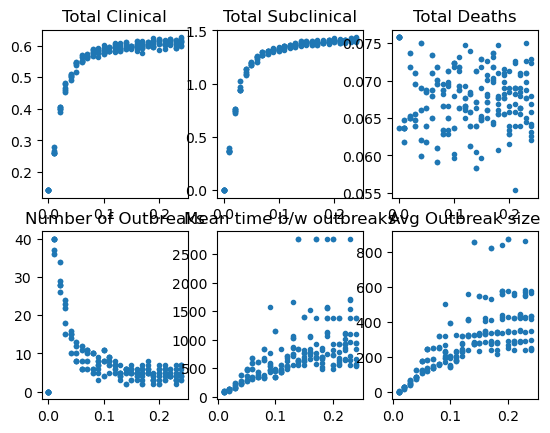

In [35]:
fig, ax = plt.subplots(2,3)
ax[0,0].plot(b0_range, [x["n_Cc"]/x["N"] for x in b0_sims], '.')
ax[0,0].set_title("Total Clinical")
ax[0,1].plot(b0_range, [x["n_Csc"]/x["N"] for x in b0_sims], '.')
ax[0,1].set_title("Total Subclinical")
ax[0,2].plot(b0_range, [x["n_D"]/x["N"] for x in b0_sims], '.')
ax[0,2].set_title("Total Deaths")
ax[1,0].plot(b0_range, [x["num_outbreaks"] for x in b0_sims], '.')
ax[1,0].set_title("Number of Outbreaks")
ax[1,1].plot(b0_range, [x["mean_time_bw_outbreaks"] for x in b0_sims], '.')
ax[1,1].set_title("Mean time b/w outbreaks")
ax[1,2].plot(b0_range, [x["avg_outbreak_size"] for x in b0_sims], '.')
ax[1,2].set_title("Avg Outbreak size")

## Varying t-reinf
From 30 days to 2 years



In [36]:
t_reinf_range = np.arange(30*24, 365*2*24, 30*24).repeat(10)
t_reinf_range

t_reinf_params = deepcopy(baseline_params)
del t_reinf_params["T_REINFECTION"]

def sim_fn(t_reinf):
    return BICS_ABM(T_REINFECTION= t_reinf, **t_reinf_params)

t_reinf_raw = Parallel(n_jobs=8, verbose = 10)(delayed(sim_fn)(v) for v in t_reinf_range)

with open('sims/t_reinf_raw.pkl', 'wb') as f:
    pickle.dump(t_reinf_raw, f)
    
t_reinf_sims = [process_sim(x) for x in t_reinf_raw]



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  4.1min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  8.0min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 16.1min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 20.3min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed: 24.7min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 29.3min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed: 37.6min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed: 45.7min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed: 54.3min


[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088 

 2431 3360 1093 3223 5378 1831][4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 

 3109 1414  164 3057  644 1152 4279 2164 4887 1380 5088 2820 3242 3697
 4224 2985  185 2577 1852 1685 2776 1748 3741 4549  992 5264  305 2767
 2649  957 3961 2057 3647 1296 1093 1698 4617   80 3641 4550  858 3427
 2234 3324 1619 4085 5118  733 3911 5043   15 2994  956 1464 1386 4237
 4257 2410  670 2064 1132 2057 4109 1175 4213 4535 3809 5148 3294 3060
 4017 1234 2230  893 3535 2669 5402 1006 2909 2091  895 4250 5216 4835
  136 4820  246 4439  996 1991  322 2469  917 1729 3896 2771 1834 3404
 4051 2525 2779 3246 2123 5291 2974  404  500 3753 2454 3961 4681  893
 4578 4209 5041 4366 2067 3681 1485 1483  882 4983 1881  895 2222  705
 1990 4743 1842 4718 4131 3172 3100 1066 5337 1157 5224 1719  516 1637
 5334 3215 3716 5149 3392 1304 4839 1393  821 2941 2266 1482 5389  855
 4969 1307  254 2802 4713 3993  946 2057 1683  569 1313 2721 2680 4830
 1093 3022 2120  828 5084 3851 4463 1565  469 2989  312 1372 1678  296
 2367  505 1341 3286 2122 1638 3280 4274 2967 1296 4426 1483 1073 1011
  676 

 2431 3360 1093 3223 5378 1831][4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 

 2431 3360 1093 3223 5378 1831][4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 

 2431 3360 1093 3223 5378 1831][4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 

 2431 3360 1093 3223 5378 1831][4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 

 2431 3360 1093 3223 5378 1831][4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 

 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088 3339 4367 3617 2730 3020 1483 1381  491 1678 5098 2122 3800 4378
 3824 2903  127 1011  557 3293 3004 1850  373 4859 4806 2994 4779 4367
  961 4408 5298 5226 3060 3169 2866 2015 3261  209 3249 4319  164 1233
 1901 1168 2456 2423 2703 2015 3305 5297 2513 2051 2726 2826  132 2183
 3232  903  473 3551 4778   60 4201 2367 1804  150 5320 1088 3434 1638
 3515 3950  238 5092  261 4739 3788 4001 2061 4122 2642 1846 2850 4859
 4195 3075 2651 5242  285  477 4690 2525 3915 2950  797 1217 2108 2217
 5158 3552 2657 2116 3466    0 4611 2729 5161 4436 4463 2989  221  610
 3382 

 2431 3360 1093 3223 5378 1831][4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 

[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed: 59.2min
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed: 72.5min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 82.1min
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed: 91.1min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 100.0min



[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088

 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088 3339 4367 3617 2730 3020 1483 1381  491 1678 5098 2122 3800 4378
 3824 2903  127 1011  557 3293 3004 1850  373 4859 4806 2994 4779 4367
  961 4408 5298 5226 3060 3169 2866 2015 3261  209 3249 4319  164 1233
 1901 1168 2456 2423 2703 2015 3305 5297 2513 2051 2726 2826  132 2183
 3232  903  473 3551 4778   60 4201 2367 1804  150 5320 1088 3434 1638
 3515 3950  238 5092  261 4739 3788 4001 2061 4122 2642 1846 2850 4859
 4195 3075 2651 5242  285  477 4690 2525 3915 2950  797 1217 2108 2217
 5158 3552 2657 2116 3466    0 4611 2729 5161 4436 4463 2989  221  610
 3382 3466 4815 4803 3966  887 1875 4373 3559  890 3969  209 3200 2412
 5326  170  453 3282 5054 4823  629 1321 2840 3947 2411 2552 3553 4679
 5394 

 4224 1487   18 4102  346 3279  483 1999 2453 2215 1736  991 3807  890
  852 2464 1377  624  825  467 2805  590  857  952 5184 1249 1404 3290
  551 1405 4530 2039 3898 3746 4224 3199 1349 3633 1605 3339   49 5255
 4512 4730 2058 3246 5019 4511 4471 4111 2980 2053 3111 2065 1546 4521
 5150 4823 2657 3240 2715 1494 4779 2632 5150 1748 2148 4110 1329 2272
 1912 2418 5272 1463 2442   49  613  223 1291 3943 2043 3679  959  443
 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 5150 4823 2657 3240 2715 1494 4779 2632 5150 1748 2148 4110 1329 2272
 1912 2418 5272 1463 2442   49  613  223 1291 3943 2043 3679  959  443
 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297

 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088 3339 4367 3617 2730 3020 1483 1381  491 1678 5098 2122 3800 4378
 3824 

 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088 3339 4367 3617 2730 3020 1483 1381  491 1678 5098 2122 3800 4378
 3824 2903  127 1011  557 3293 3004 1850  373 4859 4806 2994 4779 4367
  961 4408 5298 5226 3060 3169 2866 2015 3261  209 3249 4319  164 1233
 1901 1168 2456 2423 2703 2015 3305 5297 2513 2051 2726 2826  132 2183
 3232  903  473 3551 4778   60 4201 2367 1804  150 5320 1088 3434 1638
 3515 3950  238 5092  261 4739 3788 4001 2061 4122 2642 1846 2850 4859
 4195 3075 2651 5242  285  477 4690 2525 3915 2950  797 1217 2108 2217
 5158 3552 2657 2116 3466    0 4611 2729 5161 4436 4463 2989  221  610
 3382 3466 4815 4803 3966  887 1875 4373 3559  890 3969  209 3200 2412
 5326  170  453 3282 5054 4823  629 1321 2840 3947 2411 2552 3553 4679
 5394 3752 3487 3565 4102 3399 1312 2769 1016 2746 1873  363 1467 1508
 4069 4680 3009 2637 3670  560 2751  190 2042 1954 2724   61 1759  329
 5399 

 5158 3552 2657 2116 3466    0 4611 2729 5161 4436 4463 2989  221  610
 3382 3466 4815 4803 3966  887 1875 4373 3559  890 3969  209 3200 2412
 5326  170  453 3282 5054 4823  629 1321 2840 3947 2411 2552 3553 4679
 5394 3752 3487 3565 4102 3399 1312 2769 1016 2746 1873  363 1467 1508
 4069 4680 3009 2637 3670  560 2751  190 2042 1954 2724   61 1759  329
 5399 3079 2227 4983  592 1577 1618  526 2057 4715  597 5198 4764 3920
 4840 4669 3427 1967 5022 1349 2541 2489  537  402 3993 3007 1304 1715
 3982 2844 1837 4014 1944 1292 1676 4201 1795 1079 1450 4904 4476 2061
  264 4228 3063 1591 4105  692 1817  252 1445 5191  632 3875 5342 1504
 3414 2941  449 3743 1866 1309 4950 1722 3395 3959 2155 1781 1553 2368
  806 1370 5292 2460 2392  296 3998 1483 2598 4531 5333  935 4704 2904
 4418 4159 3980 4164 3481 3662 1106 3649 1931 3652 1495 5104 4652 4488
 4147  136 5171 4589 1875 2296 3073 2615 1838 1063 2270 3133 3294 2979
 4671  546 2708 2827 4404 1379 3680 1913 3569 2128  586 1374 3673  221
 3109 

 4418 4159 3980 4164 3481 3662 1106 3649 1931 3652 1495 5104 4652 4488
 4147  136 5171 4589 1875 2296 3073 2615 1838 1063 2270 3133 3294 2979
 4671  546 2708 2827 4404 1379 3680 1913 3569 2128  586 1374 3673  221
 3109 1414  164 3057  644 1152 4279 2164 4887 1380 5088 2820 3242 3697
 4224 2985  185 2577 1852 1685 2776 1748 3741 4549  992 5264  305 2767
 2649  957 3961 2057 3647 1296 1093 1698 4617   80 3641 4550  858 3427
 2234 3324 1619 4085 5118  733 3911 5043   15 2994  956 1464 1386 4237
 4257 2410  670 2064 1132 2057 4109 1175 4213 4535 3809 5148 3294 3060
 4017 1234 2230  893 3535 2669 5402 1006 2909 2091  895 4250 5216 4835
  136 4820  246 4439  996 1991  322 2469  917 1729 3896 2771 1834 3404
 4051 2525 2779 3246 2123 5291 2974  404  500 3753 2454 3961 4681  893
 4578 4209 5041 4366 2067 3681 1485 1483  882 4983 1881  895 2222  705
 1990 4743 1842 4718 4131 3172 3100 1066 5337 1157 5224 1719  516 1637
 5334 3215 3716 5149 3392 1304 4839 1393  821 2941 2266 1482 5389  855
 4969 

 1912 2418 5272 1463 2442   49  613  223 1291 3943 2043 3679  959  443
 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897

 4195 3075 2651 5242  285  477 4690 2525 3915 2950  797 1217 2108 2217
 5158 3552 2657 2116 3466    0 4611 2729 5161 4436 4463 2989  221  610
 3382 3466 4815 4803 3966  887 1875 4373 3559  890 3969  209 3200 2412
 5326  170  453 3282 5054 4823  629 1321 2840 3947 2411 2552 3553 4679
 5394 3752 3487 3565 4102 3399 1312 2769 1016 2746 1873  363 1467 1508
 4069 4680 3009 2637 3670  560 2751  190 2042 1954 2724   61 1759  329
 5399 3079 2227 4983  592 1577 1618  526 2057 4715  597 5198 4764 3920
 4840 4669 3427 1967 5022 1349 2541 2489  537  402 3993 3007 1304 1715
 3982 2844 1837 4014 1944 1292 1676 4201 1795 1079 1450 4904 4476 2061
  264 4228 3063 1591 4105  692 1817  252 1445 5191  632 3875 5342 1504
 3414 2941  449 3743 1866 1309 4950 1722 3395 3959 2155 1781 1553 2368
  806 1370 5292 2460 2392  296 3998 1483 2598 4531 5333  935 4704 2904
 4418 4159 3980 4164 3481 3662 1106 3649 1931 3652 1495 5104 4652 4488
 4147  136 5171 4589 1875 2296 3073 2615 1838 1063 2270 3133 3294 2979
 4671 

 4969 1307  254 2802 4713 3993  946 2057 1683  569 1313 2721 2680 4830
 1093 3022 2120  828 5084 3851 4463 1565  469 2989  312 1372 1678  296
 2367  505 1341 3286 2122 1638 3280 4274 2967 1296 4426 1483 1073 1011
  676  983  929 4372 4899 1703 1550  314 5164 5098 1703 2214 5028 2913
 2145 4670 2011 4826  192  844 1878   17 2675 3372 4732 4378 1870   81
 1612 3228 2131 2723 1653 3618 3065 3442 1446   71 2979 4825  309 2903
 4879 3781 3882 4418 3912 4785  467 1254  852 2999  406 1424  313 4228
 3829  280 3015 2220  495 3931 4894 3311  479 1525  432 1521 1862 4079
 4507  516  472  914  893 4780 1851 2525 1015 4541 2828 2192 2273 1093
 2304 3754 1305 4471 1170 5314 1307 2721 1569 4508  835 4584  546 3914
 3210 4265 4634 3123 3028 2423 1810  241 5003 2089 4829 4304 4398  272
 3428 2247 1332 1308 4279 1772 1145 3430   32 3200 1795 4650 1792 1806
 2021 1483 4463 3510 1289  739 2749 3873  264  395  469 5191 4007 5005
 3458 4214 5337  705 3085 5348 5406 3121  713 2575 1385 2086 1467 4742
 4048 

 4671  546 2708 2827 4404 1379 3680 1913 3569 2128  586 1374 3673  221
 3109 1414  164 3057  644 1152 4279 2164 4887 1380 5088 2820 3242 3697
 4224 2985  185 2577 1852 1685 2776 1748 3741 4549  992 5264  305 2767
 2649  957 3961 2057 3647 1296 1093 1698 4617   80 3641 4550  858 3427
 2234 3324 1619 4085 5118  733 3911 5043   15 2994  956 1464 1386 4237
 4257 2410  670 2064 1132 2057 4109 1175 4213 4535 3809 5148 3294 3060
 4017 1234 2230  893 3535 2669 5402 1006 2909 2091  895 4250 5216 4835
  136 4820  246 4439  996 1991  322 2469  917 1729 3896 2771 1834 3404
 4051 2525 2779 3246 2123 5291 2974  404  500 3753 2454 3961 4681  893
 4578 4209 5041 4366 2067 3681 1485 1483  882 4983 1881  895 2222  705
 1990 4743 1842 4718 4131 3172 3100 1066 5337 1157 5224 1719  516 1637
 5334 3215 3716 5149 3392 1304 4839 1393  821 2941 2266 1482 5389  855
 4969 1307  254 2802 4713 3993  946 2057 1683  569 1313 2721 2680 4830
 1093 3022 2120  828 5084 3851 4463 1565  469 2989  312 1372 1678  296
 2367 

 4257 2410  670 2064 1132 2057 4109 1175 4213 4535 3809 5148 3294 3060
 4017 1234 2230  893 3535 2669 5402 1006 2909 2091  895 4250 5216 4835
  136 4820  246 4439  996 1991  322 2469  917 1729 3896 2771 1834 3404
 4051 2525 2779 3246 2123 5291 2974  404  500 3753 2454 3961 4681  893
 4578 4209 5041 4366 2067 3681 1485 1483  882 4983 1881  895 2222  705
 1990 4743 1842 4718 4131 3172 3100 1066 5337 1157 5224 1719  516 1637
 5334 3215 3716 5149 3392 1304 4839 1393  821 2941 2266 1482 5389  855
 4969 1307  254 2802 4713 3993  946 2057 1683  569 1313 2721 2680 4830
 1093 3022 2120  828 5084 3851 4463 1565  469 2989  312 1372 1678  296
 2367  505 1341 3286 2122 1638 3280 4274 2967 1296 4426 1483 1073 1011
  676  983  929 4372 4899 1703 1550  314 5164 5098 1703 2214 5028 2913
 2145 4670 2011 4826  192  844 1878   17 2675 3372 4732 4378 1870   81
 1612 3228 2131 2723 1653 3618 3065 3442 1446   71 2979 4825  309 2903
 4879 3781 3882 4418 3912 4785  467 1254  852 2999  406 1424  313 4228
 3829 

[Parallel(n_jobs=8)]: Done 205 tasks      | elapsed: 113.1min
[Parallel(n_jobs=8)]: Done 240 out of 240 | elapsed: 130.5min finished


0.050000012
120.0
1.7224915473435194
0.625
0.050000012
120.0
1.7224915473435194
0.625
0.050000012
120.0
1.7224915473435194
0.625
0.050000012
120.0
1.7224915473435194
0.625
0.050000012
120.0
1.7224915473435194
0.625
0.050000012
120.0
1.7224915473435194
0.625
0.050000012
120.0
1.7224915473435194
0.625
0.050000012
120.0
1.7224915473435194
0.625
0.050000012
120.0
1.723367196778355
0.625
0.050000012
120.0
1.723367196778355
0.625
0.050000012
120.0
1.7347131082599467
0.625
0.050000012
120.0
1.7347131082599467
0.625
0.050000012
120.0
1.7347131082599467
0.625
0.050000012
120.0
1.7347131082599467
0.625
0.050000012
120.0
1.7347131082599467
0.625
0.050000012
120.0
1.7347131082599467
0.625
0.050000012
120.0
1.7346352833184477
0.625
0.050000012
120.0
1.7346352833184477
0.625
0.050000012
120.0
1.7346352833184477
0.625
0.050000012
120.0
1.7346352833184477
0.625
0.050000012
120.0
1.7426962301568247
0.625
0.050000012
120.0
1.7426962301568247
0.625
0.050000012
120.0
1.7409852554683771
0.625
0.050000012
1

0.050000012
120.0
1.7593808409120737
0.625
0.050000012
120.0
1.7528298128603303
0.625
0.050000012
120.0
1.7528298128603303
0.625
0.050000012
120.0
1.7581937764695714
0.625
0.050000012
120.0
1.7581937764695714
0.625
0.050000012
120.0
1.7466381699622577
0.625
0.050000012
120.0
1.7466381699622577
0.625
0.050000012
120.0
1.74095249162097
0.625
0.050000012
120.0
1.757644485846082
0.625
0.050000012
120.0
1.757644485846082
0.625
0.050000012
120.0
1.74095249162097
0.625
0.050000012
120.0
1.7573279553886685
0.625
0.050000012
120.0
1.7573279553886685
0.625
0.050000012
120.0
1.7512432495590409
0.625
0.050000012
120.0
1.7512432495590409
0.625
0.050000012
120.0
1.7435052242891032
0.625
0.050000012
120.0
1.7435052242891032
0.625
0.050000012
120.0
1.754573289701556
0.625
0.050000012
120.0
1.754573289701556
0.625
0.050000012
120.0
1.7538637747409462
0.625
0.050000012
120.0
1.7538637747409462
0.625
0.050000012
120.0
1.7606472716534303
0.625
0.050000012
120.0
1.7606472716534303
0.625
0.050000012
120.0
1

Text(0.5, 1.0, 'Avg Outbreak size')

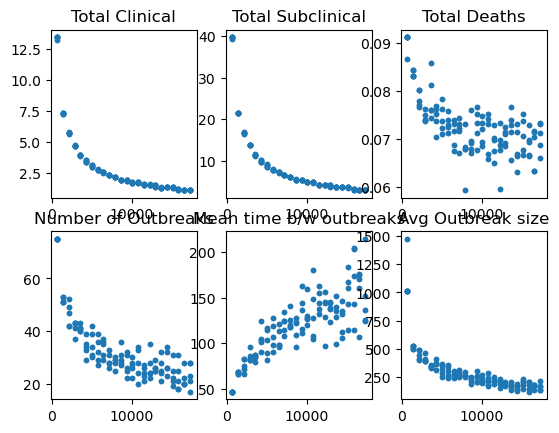

In [37]:
fig, ax = plt.subplots(2,3)
ax[0,0].plot(t_reinf_range, [x["n_Cc"]/x["N"] for x in t_reinf_sims], '.')
ax[0,0].set_title("Total Clinical")
ax[0,1].plot(t_reinf_range, [x["n_Csc"]/x["N"] for x in t_reinf_sims], '.')
ax[0,1].set_title("Total Subclinical")
ax[0,2].plot(t_reinf_range, [x["n_D"]/x["N"] for x in t_reinf_sims], '.')
ax[0,2].set_title("Total Deaths")
ax[1,0].plot(t_reinf_range, [x["num_outbreaks"] for x in t_reinf_sims], '.')
ax[1,0].set_title("Number of Outbreaks")
ax[1,1].plot(t_reinf_range, [x["mean_time_bw_outbreaks"] for x in t_reinf_sims], '.')
ax[1,1].set_title("Mean time b/w outbreaks")
ax[1,2].plot(t_reinf_range, [x["avg_outbreak_size"] for x in t_reinf_sims], '.')
ax[1,2].set_title("Avg Outbreak size")

## Adding annual booster shots
Want to include analysis of timings and uptake

In [38]:
boost_day_range = np.arange(30*24, 365*24, 30*24).repeat(10)
boost_day_range

boost_day_params = deepcopy(baseline_params)
del boost_day_params["BOOSTER_DAY"]

def sim_fn(boost_day):
    return BICS_ABM(BOOSTER_DAY = boost_day, **boost_day_params)

boost_day_raw = Parallel(n_jobs=8, verbose = 10)(delayed(sim_fn)(v) for v in boost_day_range)

with open('sims/boost_day_normal.pkl', 'wb') as f:
    pickle.dump(boost_day_raw, f)
    
boost_day_sims = [process_sim(x) for x in boost_day_raw]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  4.5min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  8.3min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  8.9min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 16.8min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 21.5min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed: 25.9min



[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

  852 2464 1377  624  825  467 2805  590  857  952 5184 1249 1404 3290
  551 1405 4530 2039 3898 3746 4224 3199 1349 3633 1605 3339   49 5255
 4512 4730 2058 3246 5019 4511 4471 4111 2980 2053 3111 2065 1546 4521
 5150 4823 2657 3240 2715 1494 4779 2632 5150 1748 2148 4110 1329 2272
 1912 2418 5272 1463 2442   49  613  223 1291 3943 2043 3679  959  443
 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 30.8min



[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088

[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed: 39.6min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed: 48.7min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed: 58.1min
[Parallel(n_jobs=8)]: Done 118 out of 120 | elapsed: 67.6min remaining:  1.1min
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed: 67.8min finished


0.050000012
120.0
1.7583598701290386
0.625
0.050000012
120.0
1.7523790386603797
0.625
0.050000012
120.0
1.7524903845230435
0.625
0.050000012
120.0
1.7571541341349033
0.625
0.050000012
120.0
1.7524903845230435
0.625
0.050000012
120.0
1.7583598701290386
0.625
0.050000012
120.0
1.7523790386603797
0.625
0.050000012
120.0
1.7571541341349033
0.625
0.050000012
120.0
1.754291281327328
0.625
0.050000012
120.0
1.754291281327328
0.625
0.050000012
120.0
1.7514118889390402
0.625
0.050000012
120.0
1.7514118889390402
0.625
0.050000012
120.0
1.7499772021562996
0.625
0.050000012
120.0
1.7499772021562996
0.625
0.050000012
120.0
1.7508191121909686
0.625
0.050000012
120.0
1.7508191121909686
0.625
0.050000012
120.0
1.7414057851319034
0.625
0.050000012
120.0
1.7414057851319034
0.625
0.050000012
120.0
1.74669128116727
0.625
0.050000012
120.0
1.74669128116727
0.625
0.050000012
120.0
1.7536534138744575
0.625
0.050000012
120.0
1.7567515445585125
0.625
0.050000012
120.0
1.7567515445585125
0.625
0.050000012
120.0

Text(0.5, 1.0, 'Avg Outbreak size')

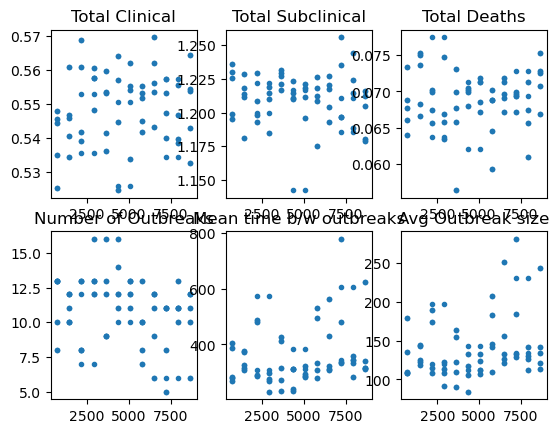

In [39]:
fig, ax = plt.subplots(2,3)
ax[0,0].plot(boost_day_range, [x["n_Cc"]/x["N"] for x in boost_day_sims], '.')
ax[0,0].set_title("Total Clinical")
ax[0,1].plot(boost_day_range, [x["n_Csc"]/x["N"] for x in boost_day_sims], '.')
ax[0,1].set_title("Total Subclinical")
ax[0,2].plot(boost_day_range, [x["n_D"]/x["N"] for x in boost_day_sims], '.')
ax[0,2].set_title("Total Deaths")
ax[1,0].plot(boost_day_range, [x["num_outbreaks"] for x in boost_day_sims], '.')
ax[1,0].set_title("Number of Outbreaks")
ax[1,1].plot(boost_day_range, [x["mean_time_bw_outbreaks"] for x in boost_day_sims], '.')
ax[1,1].set_title("Mean time b/w outbreaks")
ax[1,2].plot(boost_day_range, [x["avg_outbreak_size"] for x in boost_day_sims], '.')
ax[1,2].set_title("Avg Outbreak size")

High uptake: 

In [40]:
boost_day_range = np.arange(30*24, 365*24, 30*24).repeat(10)
boost_day_range

boost_day_params = deepcopy(baseline_params)
del boost_day_params["BOOSTER_DAY"]
boost_day_params['vax_rules']= [VaccineRule(general=True, hesitancy=0.90)]

def sim_fn(boost_day):
    return BICS_ABM(BOOSTER_DAY = boost_day, **boost_day_params)

boost_day_raw = Parallel(n_jobs=8, verbose = 10)(delayed(sim_fn)(v) for v in boost_day_range)

with open('sims/boost_day_highuptake.pkl', 'wb') as f:
    pickle.dump(boost_day_raw, f)
    
boost_day_sims = [process_sim(x) for x in boost_day_raw]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  4.7min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  9.3min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  9.4min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 18.5min



[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 4879 3781 3882 4418 3912 4785  467 1254  852 2999  406 1424  313 4228
 3829  280 3015 2220  495 3931 4894 3311  479 1525  432 1521 1862 4079
 4507  516  472  914  893 4780 1851 2525 1015 4541 2828 2192 2273 1093
 2304 3754 1305 4471 1170 5314 1307 2721 1569 4508  835 4584  546 3914
 3210 4265 4634 3123 3028 2423 1810  241 5003 2089 4829 4304 4398  272
 3428 2247 1332 1308 4279 1772 1145 3430   32 3200 1795 4650 1792 1806
 2021 1483 4463 3510 1289  739 2749 3873  264  395  469 5191 4007 5005
 3458 4214 5337  705 3085 5348 5406 3121  713 2575 1385 2086 1467 4742
 4048  976  556 3685 3136 5417 1024  345 3962 1078   64 4998 4902  870
 3410 2319  546 1074 5028  897 1061 4751 2541 3745 3499 2464 4432 1472
 1986 2930 1088 1990 4704 5277  146 2569 5028 4489 4441  296 4654 2779
 2726 4367 4148  882 4530 1273 2426 1591 1679   59  824 3781 1256 3623
 4839 1071 1983 3699 1140 4111 1967 1983 2227 2672  929 1512  713 1835
 4224 1487   18 4102  346 3279  483 1999 2453 2215 1736  991 3807  890
  852 

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 4840 4669 3427 1967 5022 1349 2541 2489  537  402 3993 3007 1304 1715
 3982 2844 1837 4014 1944 1292 1676 4201 1795 1079 1450 4904 4476 2061
  264 4228 3063 1591 4105  692 1817  252 1445 5191  632 3875 5342 1504
 3414 2941  449 3743 1866 1309 4950 1722 3395 3959 2155 1781 1553 2368
  806 1370 5292 2460 2392  296 3998 1483 2598 4531 5333  935 4704 2904
 4418 4159 3980 4164 3481 3662 1106 3649 1931 3652 1495 5104 4652 4488
 4147  136 5171 4589 1875 2296 3073 2615 1838 1063 2270 3133 3294 2979
 4671  546 2708 2827 4404 1379 3680 1913 3569 2128  586 1374 3673  221
 3109 1414  164 3057  644 1152 4279 2164 4887 1380 5088 2820 3242 3697
 4224 2985  185 2577 1852 1685 2776 1748 3741 4549  992 5264  305 2767
 2649  957 3961 2057 3647 1296 1093 1698 4617   80 3641 4550  858 3427
 2234 3324 1619 4085 5118  733 3911 5043   15 2994  956 1464 1386 4237
 4257 2410  670 2064 1132 2057 4109 1175 4213 4535 3809 5148 3294 3060
 4017 1234 2230  893 3535 2669 5402 1006 2909 2091  895 4250 5216 4835
  136 

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 4257 2410  670 2064 1132 2057 4109 1175 4213 4535 3809 5148 3294 3060
 4017 1234 2230  893 3535 2669 5402 1006 2909 2091  895 4250 5216 4835
  136 4820  246 4439  996 1991  322 2469  917 1729 3896 2771 1834 3404
 4051 2525 2779 3246 2123 5291 2974  404  500 3753 2454 3961 4681  893
 4578 4209 5041 4366 2067 3681 1485 1483  882 4983 1881  895 2222  705
 1990 4743 1842 4718 4131 3172 3100 1066 5337 1157 5224 1719  516 1637
 5334 3215 3716 5149 3392 1304 4839 1393  821 2941 2266 1482 5389  855
 4969 1307  254 2802 4713 3993  946 2057 1683  569 1313 2721 2680 4830
 1093 3022 2120  828 5084 3851 4463 1565  469 2989  312 1372 1678  296
 2367  505 1341 3286 2122 1638 3280 4274 2967 1296 4426 1483 1073 1011
  676  983  929 4372 4899 1703 1550  314 5164 5098 1703 2214 5028 2913
 2145 4670 2011 4826  192  844 1878   17 2675 3372 4732 4378 1870   81
 1612 3228 2131 2723 1653 3618 3065 3442 1446   71 2979 4825  309 2903
 4879 3781 3882 4418 3912 4785  467 1254  852 2999  406 1424  313 4228
 3829 

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 23.3min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed: 28.2min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 33.1min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed: 42.4min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed: 51.7min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed: 61.1min
[Parallel(n_jobs=8)]: Done 118 out of 120 | elapsed: 70.7min remaining:  1.2min
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed: 70.7min finished


0.050000012
120.0
1.7511487665940002
0.625
0.050000012
120.0
1.7636710834637808
0.625
0.050000012
120.0
1.7507169744579636
0.625
0.050000012
120.0
1.749365348910166
0.625
0.050000012
120.0
1.7507169744579636
0.625
0.050000012
120.0
1.749365348910166
0.625
0.050000012
120.0
1.7636710834637808
0.625
0.050000012
120.0
1.7511487665940002
0.625
0.050000012
120.0
1.7655658782215646
0.625
0.050000012
120.0
1.7655658782215646
0.625
0.050000012
120.0
1.7635295386811867
0.625
0.050000012
120.0
1.7635295386811867
0.625
0.050000012
120.0
1.75497131042585
0.625
0.050000012
120.0
1.75497131042585
0.625
0.050000012
120.0
1.7487231190798593
0.625
0.050000012
120.0
1.7487231190798593
0.625
0.050000012
120.0
1.7537403861236225
0.625
0.050000012
120.0
1.7537403861236225
0.625
0.050000012
120.0
1.7577198106835434
0.625
0.050000012
120.0
1.7496385228898774
0.625
0.050000012
120.0
1.7496385228898774
0.625
0.050000012
120.0
1.7475475459926313
0.625
0.050000012
120.0
1.7475475459926313
0.625
0.050000012
120.0

Text(0.5, 1.0, 'Avg Outbreak size')

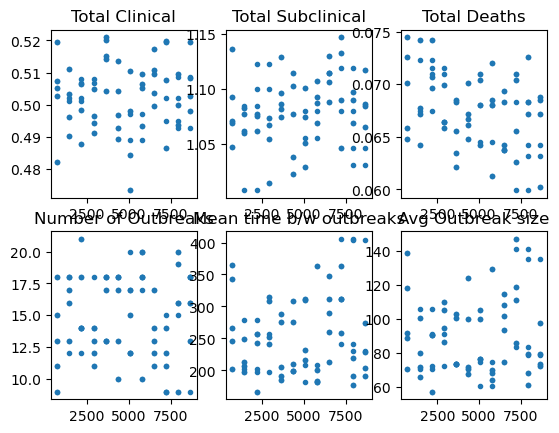

In [41]:
fig, ax = plt.subplots(2,3)
ax[0,0].plot(boost_day_range, [x["n_Cc"]/x["N"] for x in boost_day_sims], '.')
ax[0,0].set_title("Total Clinical")
ax[0,1].plot(boost_day_range, [x["n_Csc"]/x["N"] for x in boost_day_sims], '.')
ax[0,1].set_title("Total Subclinical")
ax[0,2].plot(boost_day_range, [x["n_D"]/x["N"] for x in boost_day_sims], '.')
ax[0,2].set_title("Total Deaths")
ax[1,0].plot(boost_day_range, [x["num_outbreaks"] for x in boost_day_sims], '.')
ax[1,0].set_title("Number of Outbreaks")
ax[1,1].plot(boost_day_range, [x["mean_time_bw_outbreaks"] for x in boost_day_sims], '.')
ax[1,1].set_title("Mean time b/w outbreaks")
ax[1,2].plot(boost_day_range, [x["avg_outbreak_size"] for x in boost_day_sims], '.')
ax[1,2].set_title("Avg Outbreak size")

Low uptake

In [42]:
boost_day_range = np.arange(30*24, 365*24, 30*24).repeat(10)
boost_day_range

boost_day_params = deepcopy(baseline_params)
del boost_day_params["BOOSTER_DAY"]
boost_day_params['vax_rules']= [VaccineRule(general=True, hesitancy=0.25)]

def sim_fn(boost_day):
    return BICS_ABM(BOOSTER_DAY = boost_day, **boost_day_params)

boost_day_raw = Parallel(n_jobs=8, verbose = 10)(delayed(sim_fn)(v) for v in boost_day_range)

with open('sims/boost_day_low.pkl', 'wb') as f:
    pickle.dump(boost_day_raw, f)
    
boost_day_sims = [process_sim(x) for x in boost_day_raw]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  4.3min



[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088 3339 4367 3617 2730 3020 1483 1381  491 1678 5098 2122 3800 4378
 3824 2903  127 1011  557 3293 3004 1850  373 4859 4806 2994 4779 4367
  961 4408 5298 5226 3060 3169 2866 2015 3261  209 3249 4319  164 1233
 1901 1168 2456 2423 2703 2015 3305 5297 2513 2051 2726 2826  132 2183
 3232  903  473 3551 4778   60 4201 2367 1804  150 5320 1088 3434 1638
 3515 3950  238 5092  261 4739 3788 4001 2061 4122 2642 1846 2850 4859
 4195 3075 2651 5242  285  477 4690 2525 3915 2950  797 1217 2108 2217
 5158 3552 2657 2116 3466    0 4611 2729 5161 4436 4463 2989  221  610
 3382 3466 4815 4803 3966  887 1875 4373 3559  890 3969  209 3200 2412
 5326  170  453 3282 5054 4823  629 1321 2840 3947 2411 2552 3553 4679
 5394 3752 3487 3565 4102 3399 1312 2769 1016 2746 1873  363 1467 1508
 4069 4680 3009 2637 3670  560 2751  190 2042 1954 2724   61 1759  329
 5399 

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 5326  170  453 3282 5054 4823  629 1321 2840 3947 2411 2552 3553 4679
 5394 3752 3487 3565 4102 3399 1312 2769 1016 2746 1873  363 1467 1508
 4069 4680 3009 2637 3670  560 2751  190 2042 1954 2724   61 1759  329
 5399 3079 2227 4983  592 1577 1618  526 2057 4715  597 5198 4764 3920
 4840 4669 3427 1967 5022 1349 2541 2489  537  402 3993 3007 1304 1715
 3982 2844 1837 4014 1944 1292 1676 4201 1795 1079 1450 4904 4476 2061
  264 4228 3063 1591 4105  692 1817  252 1445 5191  632 3875 5342 1504
 3414 2941  449 3743 1866 1309 4950 1722 3395 3959 2155 1781 1553 2368
  806 1370 5292 2460 2392  296 3998 1483 2598 4531 5333  935 4704 2904
 4418 4159 3980 4164 3481 3662 1106 3649 1931 3652 1495 5104 4652 4488
 4147  136 5171 4589 1875 2296 3073 2615 1838 1063 2270 3133 3294 2979
 4671  546 2708 2827 4404 1379 3680 1913 3569 2128  586 1374 3673  221
 3109 1414  164 3057  644 1152 4279 2164 4887 1380 5088 2820 3242 3697
 4224 2985  185 2577 1852 1685 2776 1748 3741 4549  992 5264  305 2767
 2649 

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 5394 3752 3487 3565 4102 3399 1312 2769 1016 2746 1873  363 1467 1508
 4069 4680 3009 2637 3670  560 2751  190 2042 1954 2724   61 1759  329
 5399 3079 2227 4983  592 1577 1618  526 2057 4715  597 5198 4764 3920
 4840 4669 3427 1967 5022 1349 2541 2489  537  402 3993 3007 1304 1715
 3982 2844 1837 4014 1944 1292 1676 4201 1795 1079 1450 4904 4476 2061
  264 4228 3063 1591 4105  692 1817  252 1445 5191  632 3875 5342 1504
 3414 2941  449 3743 1866 1309 4950 1722 3395 3959 2155 1781 1553 2368
  806 1370 5292 2460 2392  296 3998 1483 2598 4531 5333  935 4704 2904
 4418 4159 3980 4164 3481 3662 1106 3649 1931 3652 1495 5104 4652 4488
 4147  136 5171 4589 1875 2296 3073 2615 1838 1063 2270 3133 3294 2979
 4671  546 2708 2827 4404 1379 3680 1913 3569 2128  586 1374 3673  221
 3109 1414  164 3057  644 1152 4279 2164 4887 1380 5088 2820 3242 3697
 4224 2985  185 2577 1852 1685 2776 1748 3741 4549  992 5264  305 2767
 2649  957 3961 2057 3647 1296 1093 1698 4617   80 3641 4550  858 3427
 2234 

 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088 3339 4367 3617 2730 3020 1483 1381  491 1678 5098 2122 3800 4378
 3824 2903  127 1011  557 3293 3004 1850  373 4859 4806 2994 4779 4367
  961 4408 5298 5226 3060 3169 2866 2015 3261  209 3249 4319  164 1233
 1901 1168 2456 2423 2703 2015 3305 5297 2513 2051 2726 2826  132 2183
 3232  903  473 3551 4778   60 4201 2367 1804  150 5320 1088 3434 1638
 3515 

 3458 4214 5337  705 3085 5348 5406 3121  713 2575 1385 2086 1467 4742
 4048  976  556 3685 3136 5417 1024  345 3962 1078   64 4998 4902  870
 3410 2319  546 1074 5028  897 1061 4751 2541 3745 3499 2464 4432 1472
 1986 2930 1088 1990 4704 5277  146 2569 5028 4489 4441  296 4654 2779
 2726 4367 4148  882 4530 1273 2426 1591 1679   59  824 3781 1256 3623
 4839 1071 1983 3699 1140 4111 1967 1983 2227 2672  929 1512  713 1835
 4224 1487   18 4102  346 3279  483 1999 2453 2215 1736  991 3807  890
  852 2464 1377  624  825  467 2805  590  857  952 5184 1249 1404 3290
  551 1405 4530 2039 3898 3746 4224 3199 1349 3633 1605 3339   49 5255
 4512 4730 2058 3246 5019 4511 4471 4111 2980 2053 3111 2065 1546 4521
 5150 4823 2657 3240 2715 1494 4779 2632 5150 1748 2148 4110 1329 2272
 1912 2418 5272 1463 2442   49  613  223 1291 3943 2043 3679  959  443
 2431 3360 1093 3223 5378 1831]

[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  8.6min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  8.7min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 17.3min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 21.7min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed: 26.0min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 30.6min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed: 39.3min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed: 47.8min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed: 56.5min



[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088

 2145 4670 2011 4826  192  844 1878   17 2675 3372 4732 4378 1870   81
 1612 3228 2131 2723 1653 3618 3065 3442 1446   71 2979 4825  309 2903
 4879 3781 3882 4418 3912 4785  467 1254  852 2999  406 1424  313 4228
 3829  280 3015 2220  495 3931 4894 3311  479 1525  432 1521 1862 4079
 4507  516  472  914  893 4780 1851 2525 1015 4541 2828 2192 2273 1093
 2304 3754 1305 4471 1170 5314 1307 2721 1569 4508  835 4584  546 3914
 3210 4265 4634 3123 3028 2423 1810  241 5003 2089 4829 4304 4398  272
 3428 2247 1332 1308 4279 1772 1145 3430   32 3200 1795 4650 1792 1806
 2021 1483 4463 3510 1289  739 2749 3873  264  395  469 5191 4007 5005
 3458 4214 5337  705 3085 5348 5406 3121  713 2575 1385 2086 1467 4742
 4048  976  556 3685 3136 5417 1024  345 3962 1078   64 4998 4902  870
 3410 2319  546 1074 5028  897 1061 4751 2541 3745 3499 2464 4432 1472
 1986 2930 1088 1990 4704 5277  146 2569 5028 4489 4441  296 4654 2779
 2726 4367 4148  882 4530 1273 2426 1591 1679   59  824 3781 1256 3623
 4839 

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 5394 3752 3487 3565 4102 3399 1312 2769 1016 2746 1873  363 1467 1508
 4069 4680 3009 2637 3670  560 2751  190 2042 1954 2724   61 1759  329
 5399 3079 2227 4983  592 1577 1618  526 2057 4715  597 5198 4764 3920
 4840 4669 3427 1967 5022 1349 2541 2489  537  402 3993 3007 1304 1715
 3982 2844 1837 4014 1944 1292 1676 4201 1795 1079 1450 4904 4476 2061
  264 4228 3063 1591 4105  692 1817  252 1445 5191  632 3875 5342 1504
 3414 2941  449 3743 1866 1309 4950 1722 3395 3959 2155 1781 1553 2368
  806 1370 5292 2460 2392  296 3998 1483 2598 4531 5333  935 4704 2904
 4418 4159 3980 4164 3481 3662 1106 3649 1931 3652 1495 5104 4652 4488
 4147  136 5171 4589 1875 2296 3073 2615 1838 1063 2270 3133 3294 2979
 4671  546 2708 2827 4404 1379 3680 1913 3569 2128  586 1374 3673  221
 3109 1414  164 3057  644 1152 4279 2164 4887 1380 5088 2820 3242 3697
 4224 2985  185 2577 1852 1685 2776 1748 3741 4549  992 5264  305 2767
 2649  957 3961 2057 3647 1296 1093 1698 4617   80 3641 4550  858 3427
 2234 

 5399 3079 2227 4983  592 1577 1618  526 2057 4715  597 5198 4764 3920
 4840 4669 3427 1967 5022 1349 2541 2489  537  402 3993 3007 1304 1715
 3982 2844 1837 4014 1944 1292 1676 4201 1795 1079 1450 4904 4476 2061
  264 4228 3063 1591 4105  692 1817  252 1445 5191  632 3875 5342 1504
 3414 2941  449 3743 1866 1309 4950 1722 3395 3959 2155 1781 1553 2368
  806 1370 5292 2460 2392  296 3998 1483 2598 4531 5333  935 4704 2904
 4418 4159 3980 4164 3481 3662 1106 3649 1931 3652 1495 5104 4652 4488
 4147  136 5171 4589 1875 2296 3073 2615 1838 1063 2270 3133 3294 2979
 4671  546 2708 2827 4404 1379 3680 1913 3569 2128  586 1374 3673  221
 3109 1414  164 3057  644 1152 4279 2164 4887 1380 5088 2820 3242 3697
 4224 2985  185 2577 1852 1685 2776 1748 3741 4549  992 5264  305 2767
 2649  957 3961 2057 3647 1296 1093 1698 4617   80 3641 4550  858 3427
 2234 3324 1619 4085 5118  733 3911 5043   15 2994  956 1464 1386 4237
 4257 2410  670 2064 1132 2057 4109 1175 4213 4535 3809 5148 3294 3060
 4017 

 3382 3466 4815 4803 3966  887 1875 4373 3559  890 3969  209 3200 2412
 5326  170  453 3282 5054 4823  629 1321 2840 3947 2411 2552 3553 4679
 5394 3752 3487 3565 4102 3399 1312 2769 1016 2746 1873  363 1467 1508
 4069 4680 3009 2637 3670  560 2751  190 2042 1954 2724   61 1759  329
 5399 3079 2227 4983  592 1577 1618  526 2057 4715  597 5198 4764 3920
 4840 4669 3427 1967 5022 1349 2541 2489  537  402 3993 3007 1304 1715
 3982 2844 1837 4014 1944 1292 1676 4201 1795 1079 1450 4904 4476 2061
  264 4228 3063 1591 4105  692 1817  252 1445 5191  632 3875 5342 1504
 3414 2941  449 3743 1866 1309 4950 1722 3395 3959 2155 1781 1553 2368
  806 1370 5292 2460 2392  296 3998 1483 2598 4531 5333  935 4704 2904
 4418 4159 3980 4164 3481 3662 1106 3649 1931 3652 1495 5104 4652 4488
 4147  136 5171 4589 1875 2296 3073 2615 1838 1063 2270 3133 3294 2979
 4671  546 2708 2827 4404 1379 3680 1913 3569 2128  586 1374 3673  221
 3109 1414  164 3057  644 1152 4279 2164 4887 1380 5088 2820 3242 3697
 4224 

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088 3339 4367 3617 2730 3020 1483 1381  491 1678 5098 2122 3800 4378
 3824 2903  127 1011  557 3293 3004 1850  373 4859 4806 2994 4779 4367
  961 4408 5298 5226 3060 3169 2866 2015 3261  209 3249 4319  164 1233
 1901 1168 2456 2423 2703 2015 3305 5297 2513 2051 2726 2826  132 2183
 3232  903  473 3551 4778   60 4201 2367 1804  150 5320 1088 3434 1638
 3515 3950  238 5092  261 4739 3788 4001 2061 4122 2642 1846 2850 4859
 4195 3075 2651 5242  285  477 4690 2525 3915 2950  797 1217 2108 2217
 5158 3552 2657 2116 3466    0 4611 2729 5161 4436 4463 2989  221  610
 3382 3466 4815 4803 3966  887 1875 4373 3559  890 3969  209 3200 2412
 5326 

 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088 3339 4367 3617 2730 3020 1483 1381  491 1678 5098 2122 3800 4378
 3824 2903  127 1011  557 3293 3004 1850  373 4859 4806 2994 4779 4367
  961 4408 5298 5226 3060 3169 2866 2015 3261  209 3249 4319  164 1233
 1901 1168 2456 2423 2703 2015 3305 5297 2513 2051 2726 2826  132 2183
 3232  903  473 3551 4778   60 4201 2367 1804  150 5320 1088 3434 1638
 3515 3950  238 5092  261 4739 3788 4001 2061 4122 2642 1846 2850 4859
 4195 

[Parallel(n_jobs=8)]: Done 118 out of 120 | elapsed: 65.4min remaining:  1.1min
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed: 65.5min finished


0.050000012
120.0
1.750752579332687
0.625
0.050000012
120.0
1.7629974214676023
0.625
0.050000012
120.0
1.7573874977191755
0.625
0.050000012
120.0
1.7515766749256534
0.625
0.050000012
120.0
1.750752579332687
0.625
0.050000012
120.0
1.7629974214676023
0.625
0.050000012
120.0
1.7573874977191755
0.625
0.050000012
120.0
1.7515766749256534
0.625
0.050000012
120.0
1.7650614014027473
0.625
0.050000012
120.0
1.7650614014027473
0.625
0.050000012
120.0
1.761195842816763
0.625
0.050000012
120.0
1.761195842816763
0.625
0.050000012
120.0
1.7519040132912058
0.625
0.050000012
120.0
1.7519040132912058
0.625
0.050000012
120.0
1.7538163599957748
0.625
0.050000012
120.0
1.7538163599957748
0.625
0.050000012
120.0
1.7555163259034465
0.625
0.050000012
120.0
1.7555163259034465
0.625
0.050000012
120.0
1.7535834525764518
0.625
0.050000012
120.0
1.7535834525764518
0.625
0.050000012
120.0
1.7652134851962467
0.625
0.050000012
120.0
1.7629412091412255
0.625
0.050000012
120.0
1.7629412091412255
0.625
0.050000012
120

Text(0.5, 1.0, 'Avg Outbreak size')

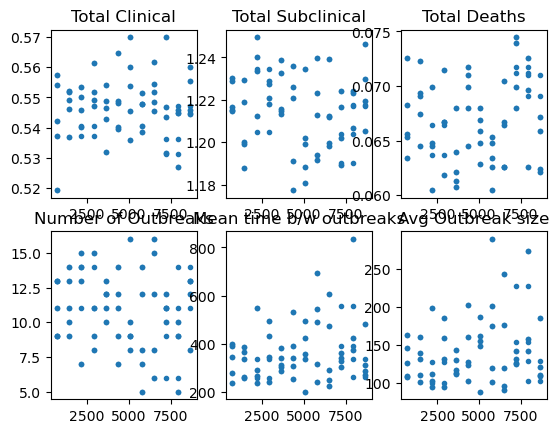

In [43]:
fig, ax = plt.subplots(2,3)
ax[0,0].plot(boost_day_range, [x["n_Cc"]/x["N"] for x in boost_day_sims], '.')
ax[0,0].set_title("Total Clinical")
ax[0,1].plot(boost_day_range, [x["n_Csc"]/x["N"] for x in boost_day_sims], '.')
ax[0,1].set_title("Total Subclinical")
ax[0,2].plot(boost_day_range, [x["n_D"]/x["N"] for x in boost_day_sims], '.')
ax[0,2].set_title("Total Deaths")
ax[1,0].plot(boost_day_range, [x["num_outbreaks"] for x in boost_day_sims], '.')
ax[1,0].set_title("Number of Outbreaks")
ax[1,1].plot(boost_day_range, [x["mean_time_bw_outbreaks"] for x in boost_day_sims], '.')
ax[1,1].set_title("Mean time b/w outbreaks")
ax[1,2].plot(boost_day_range, [x["avg_outbreak_size"] for x in boost_day_sims], '.')
ax[1,2].set_title("Avg Outbreak size")

## Seasonal forcing

In [44]:
b1_range = np.arange(0, 1, .1).repeat(10)
b1_range

b1_params = deepcopy(baseline_params)
del b1_params["BETA1"]
print(b1_params)

def sim_fn(b1):
    return BICS_ABM(BETA1= b1, **b1_params)

b1_raw = Parallel(n_jobs=8, verbose = 10)(delayed(sim_fn)(v) for v in b1_range)

with open('sims/b1_raw.pkl', 'wb') as f:
    pickle.dump(b1_raw, f)
    
b1_sims = [process_sim(x) for x in b1_raw]

{'N_HH': 1000, 'RHO': 0.25, 'ALPHA': 0.5, 'BETA0': 0.05, 'T0': 0, 'ISOLATION_MULTIPLIER': 0.1, 'N_VAX_DAILY': 150, 'T_REINFECTION': 65700, 'IMPORT_CASES_VEC': [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  4.4min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  8.8min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  8.8min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 17.7min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 22.1min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed: 26.7min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 31.3min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed: 40.0min



[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088

 2145 4670 2011 4826  192  844 1878   17 2675 3372 4732 4378 1870   81
 1612 3228 2131 2723 1653 3618 3065 3442 1446   71 2979 4825  309 2903
 4879 3781 3882 4418 3912 4785  467 1254  852 2999  406 1424  313 4228
 3829  280 3015 2220  495 3931 4894 3311  479 1525  432 1521 1862 4079
 4507  516  472  914  893 4780 1851 2525 1015 4541 2828 2192 2273 1093
 2304 3754 1305 4471 1170 5314 1307 2721 1569 4508  835 4584  546 3914
 3210 4265 4634 3123 3028 2423 1810  241 5003 2089 4829 4304 4398  272
 3428 2247 1332 1308 4279 1772 1145 3430   32 3200 1795 4650 1792 1806
 2021 1483 4463 3510 1289  739 2749 3873  264  395  469 5191 4007 5005
 3458 4214 5337  705 3085 5348 5406 3121  713 2575 1385 2086 1467 4742
 4048  976  556 3685 3136 5417 1024  345 3962 1078   64 4998 4902  870
 3410 2319  546 1074 5028  897 1061 4751 2541 3745 3499 2464 4432 1472
 1986 2930 1088 1990 4704 5277  146 2569 5028 4489 4441  296 4654 2779
 2726 4367 4148  882 4530 1273 2426 1591 1679   59  824 3781 1256 3623
 4839 

 4969 1307  254 2802 4713 3993  946 2057 1683  569 1313 2721 2680 4830
 1093 3022 2120  828 5084 3851 4463 1565  469 2989  312 1372 1678  296
 2367  505 1341 3286 2122 1638 3280 4274 2967 1296 4426 1483 1073 1011
  676  983  929 4372 4899 1703 1550  314 5164 5098 1703 2214 5028 2913
 2145 4670 2011 4826  192  844 1878   17 2675 3372 4732 4378 1870   81
 1612 3228 2131 2723 1653 3618 3065 3442 1446   71 2979 4825  309 2903
 4879 3781 3882 4418 3912 4785  467 1254  852 2999  406 1424  313 4228
 3829  280 3015 2220  495 3931 4894 3311  479 1525  432 1521 1862 4079
 4507  516  472  914  893 4780 1851 2525 1015 4541 2828 2192 2273 1093
 2304 3754 1305 4471 1170 5314 1307 2721 1569 4508  835 4584  546 3914
 3210 4265 4634 3123 3028 2423 1810  241 5003 2089 4829 4304 4398  272
 3428 2247 1332 1308 4279 1772 1145 3430   32 3200 1795 4650 1792 1806
 2021 1483 4463 3510 1289  739 2749 3873  264  395  469 5191 4007 5005
 3458 4214 5337  705 3085 5348 5406 3121  713 2575 1385 2086 1467 4742
 4048 

 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088 3339 4367 3617 2730 3020 1483 1381  491 1678 5098 2122 3800 4378
 3824 2903  127 1011  557 3293 3004 1850  373 4859 4806 2994 4779 4367
  961 4408 5298 5226 3060 3169 2866 2015 3261  209 3249 4319  164 1233
 1901 1168 2456 2423 2703 2015 3305 5297 2513 2051 2726 2826  132 2183
 3232  903  473 3551 4778   60 4201 2367 1804  150 5320 1088 3434 1638
 3515 3950  238 5092  261 4739 3788 4001 2061 4122 2642 1846 2850 4859
 4195 3075 2651 5242  285  477 4690 2525 3915 2950  797 1217 2108 2217
 5158 3552 2657 2116 3466    0 4611 2729 5161 4436 4463 2989  221  610
 3382 3466 4815 4803 3966  887 1875 4373 3559  890 3969  209 3200 2412
 5326  170  453 3282 5054 4823  629 1321 2840 3947 2411 2552 3553 4679
 5394 

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088 3339 4367 3617 2730 3020 1483 1381  491 1678 5098 2122 3800 4378
 3824 2903  127 1011  557 3293 3004 1850  373 4859 4806 2994 4779 4367
  961 4408 5298 5226 3060 3169 2866 2015 3261  209 3249 4319  164 1233
 1901 1168 2456 2423 2703 2015 3305 5297 2513 2051 2726 2826  132 2183
 3232  903  473 3551 4778   60 4201 2367 1804  150 5320 1088 3434 1638
 3515 3950  238 5092  261 4739 3788 4001 2061 4122 2642 1846 2850 4859
 4195 3075 2651 5242  285  477 4690 2525 3915 2950  797 1217 2108 2217
 5158 3552 2657 2116 3466    0 4611 2729 5161 4436 4463 2989  221  610
 3382 3466 4815 4803 3966  887 1875 4373 3559  890 3969  209 3200 2412
 5326 

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 3829  280 3015 2220  495 3931 4894 3311  479 1525  432 1521 1862 4079
 4507  516  472  914  893 4780 1851 2525 1015 4541 2828 2192 2273 1093
 2304 3754 1305 4471 1170 5314 1307 2721 1569 4508  835 4584  546 3914
 3210 4265 4634 3123 3028 2423 1810  241 5003 2089 4829 4304 4398  272
 3428 2247 1332 1308 4279 1772 1145 3430   32 3200 1795 4650 1792 1806
 2021 1483 4463 3510 1289  739 2749 3873  264  395  469 5191 4007 5005
 3458 4214 5337  705 3085 5348 5406 3121  713 2575 1385 2086 1467 4742
 4048  976  556 3685 3136 5417 1024  345 3962 1078   64 4998 4902  870
 3410 2319  546 1074 5028  897 1061 4751 2541 3745 3499 2464 4432 1472
 1986 2930 1088 1990 4704 5277  146 2569 5028 4489 4441  296 4654 2779
 2726 4367 4148  882 4530 1273 2426 1591 1679   59  824 3781 1256 3623
 4839 1071 1983 3699 1140 4111 1967 1983 2227 2672  929 1512  713 1835
 4224 1487   18 4102  346 3279  483 1999 2453 2215 1736  991 3807  890
  852 2464 1377  624  825  467 2805  590  857  952 5184 1249 1404 3290
  551 

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 2431 3360 1093 3223 5378 1831]
[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351

 3414 2941  449 3743 1866 1309 4950 1722 3395 3959 2155 1781 1553 2368
  806 1370 5292 2460 2392  296 3998 1483 2598 4531 5333  935 4704 2904
 4418 4159 3980 4164 3481 3662 1106 3649 1931 3652 1495 5104 4652 4488
 4147  136 5171 4589 1875 2296 3073 2615 1838 1063 2270 3133 3294 2979
 4671  546 2708 2827 4404 1379 3680 1913 3569 2128  586 1374 3673  221
 3109 1414  164 3057  644 1152 4279 2164 4887 1380 5088 2820 3242 3697
 4224 2985  185 2577 1852 1685 2776 1748 3741 4549  992 5264  305 2767
 2649  957 3961 2057 3647 1296 1093 1698 4617   80 3641 4550  858 3427
 2234 3324 1619 4085 5118  733 3911 5043   15 2994  956 1464 1386 4237
 4257 2410  670 2064 1132 2057 4109 1175 4213 4535 3809 5148 3294 3060
 4017 1234 2230  893 3535 2669 5402 1006 2909 2091  895 4250 5216 4835
  136 4820  246 4439  996 1991  322 2469  917 1729 3896 2771 1834 3404
 4051 2525 2779 3246 2123 5291 2974  404  500 3753 2454 3961 4681  893
 4578 4209 5041 4366 2067 3681 1485 1483  882 4983 1881  895 2222  705
 1990 

[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed: 48.7min
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed: 53.6min remaining:  2.2min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed: 56.4min finished


0.050000012
120.0
1.7603315678949512
0.625
0.050000012
120.0
1.7565146581003688
0.625
0.050000012
120.0
1.7499454338688867
0.625
0.050000012
120.0
1.7603315678949512
0.625
0.050000012
120.0
1.7565146581003688
0.625
0.050000012
120.0
1.7499454338688867
0.625
0.050000012
120.0
1.7559885758690341
0.625
0.050000012
120.0
1.7559885758690341
0.625
0.050000012
120.0
1.756813839084213
0.625
0.050000012
120.0
1.7548751364493402
0.625
0.05
120.0
1.7485346749384578
0.625
0.05
120.0
1.7597758477465453
0.625
0.05
120.0
1.749028271823091
0.625
0.05
120.0
1.7445346253205158
0.625
0.05
120.0
1.7597758477465453
0.625
0.05
120.0
1.7445346253205158
0.625
0.05
120.0
1.7442790857173953
0.625
0.05
120.0
1.7597788352268178
0.625
0.05
120.0
1.7561439080371462
0.625
0.05
120.0
1.7561439080371462
0.625
0.05
120.0
1.7594746436311368
0.625
0.05
120.0
1.764390000224081
0.625
0.05
120.0
1.7568148890638855
0.625
0.05
120.0
1.764390000224081
0.625
0.05
120.0
1.75661378274384
0.625
0.05
120.0
1.7595470298059779
0.625


Text(0.5, 1.0, 'Avg Outbreak size')

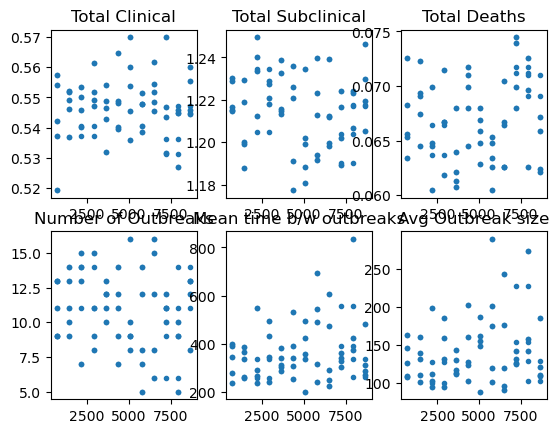

In [45]:
fig, ax = plt.subplots(2,3)
ax[0,0].plot(boost_day_range, [x["n_Cc"]/x["N"] for x in boost_day_sims], '.')
ax[0,0].set_title("Total Clinical")
ax[0,1].plot(boost_day_range, [x["n_Csc"]/x["N"] for x in boost_day_sims], '.')
ax[0,1].set_title("Total Subclinical")
ax[0,2].plot(boost_day_range, [x["n_D"]/x["N"] for x in boost_day_sims], '.')
ax[0,2].set_title("Total Deaths")
ax[1,0].plot(boost_day_range, [x["num_outbreaks"] for x in boost_day_sims], '.')
ax[1,0].set_title("Number of Outbreaks")
ax[1,1].plot(boost_day_range, [x["mean_time_bw_outbreaks"] for x in boost_day_sims], '.')
ax[1,1].set_title("Mean time b/w outbreaks")
ax[1,2].plot(boost_day_range, [x["avg_outbreak_size"] for x in boost_day_sims], '.')
ax[1,2].set_title("Avg Outbreak size")

## Seasonal forcing with booster doses

## Demography

In [46]:
# TODO


[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088

/Users/eroubenoff/BICS_ABM/BICS_ABM.py:159: DtypeWarning: Columns (26,63,64,65,66,68,69,70,71,72,73,76,86,139,140,149,175,176,177,191,195,205,213,214,215,216,217,218,219,220,221,222,223,224,225,227,228,229) have mixed types. Specify dtype option on import or set low_memory=False.
  BICS = pd.read_csv("data/df_all_waves.csv", dtype_backend="numpy_nullable")



[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088

/Users/eroubenoff/BICS_ABM/BICS_ABM.py:159: DtypeWarning: Columns (26,63,64,65,66,68,69,70,71,72,73,76,86,139,140,149,175,176,177,191,195,205,213,214,215,216,217,218,219,220,221,222,223,224,225,227,228,229) have mixed types. Specify dtype option on import or set low_memory=False.
  BICS = pd.read_csv("data/df_all_waves.csv", dtype_backend="numpy_nullable")



[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088

/Users/eroubenoff/BICS_ABM/BICS_ABM.py:159: DtypeWarning: Columns (26,63,64,65,66,68,69,70,71,72,73,76,86,139,140,149,175,176,177,191,195,205,213,214,215,216,217,218,219,220,221,222,223,224,225,227,228,229) have mixed types. Specify dtype option on import or set low_memory=False.
  BICS = pd.read_csv("data/df_all_waves.csv", dtype_backend="numpy_nullable")



[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088

/Users/eroubenoff/BICS_ABM/BICS_ABM.py:159: DtypeWarning: Columns (26,63,64,65,66,68,69,70,71,72,73,76,86,139,140,149,175,176,177,191,195,205,213,214,215,216,217,218,219,220,221,222,223,224,225,227,228,229) have mixed types. Specify dtype option on import or set low_memory=False.
  BICS = pd.read_csv("data/df_all_waves.csv", dtype_backend="numpy_nullable")



[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088

/Users/eroubenoff/BICS_ABM/BICS_ABM.py:159: DtypeWarning: Columns (26,63,64,65,66,68,69,70,71,72,73,76,86,139,140,149,175,176,177,191,195,205,213,214,215,216,217,218,219,220,221,222,223,224,225,227,228,229) have mixed types. Specify dtype option on import or set low_memory=False.
  BICS = pd.read_csv("data/df_all_waves.csv", dtype_backend="numpy_nullable")



[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088

/Users/eroubenoff/BICS_ABM/BICS_ABM.py:159: DtypeWarning: Columns (26,63,64,65,66,68,69,70,71,72,73,76,86,139,140,149,175,176,177,191,195,205,213,214,215,216,217,218,219,220,221,222,223,224,225,227,228,229) have mixed types. Specify dtype option on import or set low_memory=False.
  BICS = pd.read_csv("data/df_all_waves.csv", dtype_backend="numpy_nullable")



[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088

/Users/eroubenoff/BICS_ABM/BICS_ABM.py:159: DtypeWarning: Columns (26,63,64,65,66,68,69,70,71,72,73,76,86,139,140,149,175,176,177,191,195,205,213,214,215,216,217,218,219,220,221,222,223,224,225,227,228,229) have mixed types. Specify dtype option on import or set low_memory=False.
  BICS = pd.read_csv("data/df_all_waves.csv", dtype_backend="numpy_nullable")



[4840 3073 1929 2279 2373 4258 5111 5028 2164 2350   48 2095 1806 4443
 5383  354 3744 3009 4039 1779  472 3424 3751 1336 2846 4252  445 1864
 1083  951 2435 2994 2771 3246 5257 1817 4240 1464 3365  398 5054 4605
 5073  331 1912 1103 3324  283 4059 4053 2752 4071 3630 5411 3203  951
 1329 1015 2831  303 1552 1015 4214 2510 1740  479 1396  737 4852  714
 4757 3961 3046 3055 5065 1765 4010  791 5121 4997 5210 4206 5337 3641
 2365  954  721 1284 1642 1711 2670  416  136 5320 2270 2292 1732 5156
 1805 1652  108 4785 4661 1275 2057 5054 4010 4229  804  808  937 1239
 1756 3481 2535  844 5294 5332 4931 1199 2905 4731 2472 1747 3235   52
 2049 2872 2704 3021  951  490  345 3338 2924  824 1792 3335 3711 3294
 3242 3630 1915 1644  982 1023 1936  663 1440 2230 3119 2453 1686  503
 4030 3641  170 4454 4636 3783 2901 3105 5297  598 2596 2596  550  205
 4453 2566 3124 5296 5135 4660 2274 1106 2897 4062 1261 3612 4489 2494
 1625 5280 3841 3151 2603 2091 3302 1689 4351 3707 5208 2310 1353  996
 1088

/Users/eroubenoff/BICS_ABM/BICS_ABM.py:159: DtypeWarning: Columns (26,63,64,65,66,68,69,70,71,72,73,76,86,139,140,149,175,176,177,191,195,205,213,214,215,216,217,218,219,220,221,222,223,224,225,227,228,229) have mixed types. Specify dtype option on import or set low_memory=False.
  BICS = pd.read_csv("data/df_all_waves.csv", dtype_backend="numpy_nullable")
